In [3]:
import typing

import tensorflow as tf
print(tf.keras.__version__)
keras = typing.cast("keras", tf.keras)

3.10.0


In [1]:
import os
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor
# from google.colab import drive
import time
from collections import defaultdict

# 1. Инициализация
drive.mount('/content/drive')
pd.set_option('display.max_colwidth', None)

# 2. Настройка путей
save_dir = "/content/drive/MyDrive/product_images_500"
os.makedirs(save_dir, exist_ok=True)
print(f"Папка для сохранения: {save_dir}")

# 3. Загрузка данных
try:
    train_data = pd.read_parquet("/content/sample_data/hackaton_train_types_recom.parquet")
    test_data = pd.read_parquet("/content/sample_data/hackaton_test_types_recom.parquet")
    print("\nДанные успешно загружены:")
    print(f"Train: {len(train_data)} записей, Test: {len(test_data)} записей")
except Exception as e:
    print(f"\nОшибка загрузки данных: {str(e)}")
    raise


NameError: name 'drive' is not defined

In [ ]:
# 4. Проверка данных
print("\nПроверка данных:")
print("Есть ли target=1:", (train_data['target'] == 1).any())
print("Пустые main_photo:", train_data['main_photo'].isna().sum())
print("Пустые category_l2:", train_data['category_l2'].isna().sum())


Проверка данных:
Есть ли target=1: True
Пустые main_photo: 0
Пустые category_l2: 320606


In [ ]:
# 5. Подготовка данных с ограничением по категориям
SELECTED_CATEGORIES = [
    'Дом и сад',
    'Строительство и ремонт',
    'Автотовары',
    'Одежда',
    'Электроника'
]

all_data = pd.concat([train_data, test_data])
valid_data = all_data[
    (all_data["target"] == 1) &
    (all_data["main_photo"].notna()) &
    (all_data["category_l2"].notna()) &
    (all_data["category_l2"].isin(SELECTED_CATEGORIES))
].copy()

# Добавляем индекс как колонку
valid_data['item_index'] = valid_data.index

# Счетчик для ограничения количества изображений на категорию
category_counts = defaultdict(int)
MAX_IMAGES_PER_CATEGORY = 500  # Увеличено до 500

# Фильтрация данных - оставляем только первые 500 для каждой категории
filtered_data = []
for _, row in valid_data.iterrows():
    category = str(row["category_l2"]).replace("/", "_")
    if category in SELECTED_CATEGORIES and category_counts[category] < MAX_IMAGES_PER_CATEGORY:
        filtered_data.append(row)
        category_counts[category] += 1

valid_data = pd.DataFrame(filtered_data)
print(f"\nПосле ограничения осталось {len(valid_data)} изображений (макс. {MAX_IMAGES_PER_CATEGORY} на категорию)")


После ограничения осталось 2500 изображений (макс. 500 на категорию)


In [ ]:
# 6. Улучшенная функция загрузки с прогрессом
def download_images(item):
    try:
        category = str(item["category_l2"]).replace("/", "_")
        url = item["main_photo"].strip()
        index = item["item_index"]

        # Проверка URL
        if not url.startswith(('http://', 'https://')):
            url = f"https://cdn1.ozone.ru/{url.lstrip('/')}"

        # Создание папки
        category_dir = os.path.join(save_dir, category)
        os.makedirs(category_dir, exist_ok=True)
        img_path = os.path.join(category_dir, f"{index}.jpg")

        # Пропуск существующих
        if os.path.exists(img_path):
            return True

        # Загрузка изображения
        for attempt in range(3):
            try:
                response = requests.get(url, timeout=15,
                                     headers={'User-Agent': 'Mozilla/5.0'})
                if response.status_code == 200:
                    img = Image.open(BytesIO(response.content))

                    # Проверка и конвертация изображения
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    img.save(img_path, "JPEG", quality=85)
                    print(f"✓ Успешно: {category}/{index}.jpg")
                    return True
                else:
                    print(f"× Ошибка {response.status_code} для {url}")
            except Exception as e:
                print(f"! Попытка {attempt+1}: {str(e)}")
                time.sleep(2)

        # Логирование ошибок
        with open(os.path.join(save_dir, "failed_downloads.txt"), "a") as f:
            f.write(f"{category},{index},{url}\n")
        return False

    except Exception as e:
        print(f"!!! Критическая ошибка: {str(e)}")
        return False

# 7. Прогресс-бар для загрузки
def print_progress(current, total, category):
    progress = current / total * 100
    print(f"\rЗагрузка {category}: {current}/{total} ({progress:.1f}%)", end='')
    if current == total:
        print()

In [ ]:
# 8. Основная загрузка по категориям
def download_by_categories():
    success_count = 0
    total_count = len(valid_data)

    # Группировка по категориям
    grouped = valid_data.groupby('category_l2')

    for category, group in grouped:
        print(f"\nЗагрузка категории: {category}")
        category_count = len(group)
        downloaded = 0

        with ThreadPoolExecutor(max_workers=8) as executor:  # Увеличено кол-во потоков
            results = list(executor.map(download_images, group.to_dict('records')))

        downloaded = sum(results)
        success_count += downloaded
        print(f"Завершено: {downloaded}/{category_count} для {category}")

    return success_count

In [ ]:
# 9. Запуск загрузки
start_time = time.time()
success_count = download_by_categories()
total_time = time.time() - start_time

print(f"\nОбщее время загрузки: {total_time:.2f} сек.")
print(f"Успешно загружено: {success_count}/{len(valid_data)}")

# 10. Итоговая проверка
print("\nИтоговая проверка:")
categories = [d for d in os.listdir(save_dir)
             if os.path.isdir(os.path.join(save_dir, d))]

for category in SELECTED_CATEGORIES:
    category = category.replace("/", "_")
    if category in categories:
        count = len(os.listdir(os.path.join(save_dir, category)))
        print(f"{category}: {count} изображений")
    else:
        print(f"⚠️ {category}: 0 изображений (не загружено)")

# 11. Проверка ошибок
failed_file = os.path.join(save_dir, "failed_downloads.txt")
if os.path.exists(failed_file):
    with open(failed_file) as f:
        fails = len(f.readlines())
    print(f"\nНе загружено изображений: {fails}")
    print("Список ошибок сохранен в:", failed_file)


Загрузка категории: Автотовары
✓ Успешно: Автотовары/240796.jpg
✓ Успешно: Автотовары/315985.jpg
✓ Успешно: Автотовары/630946.jpg
✓ Успешно: Автотовары/806916.jpg
✓ Успешно: Автотовары/764284.jpg
✓ Успешно: Автотовары/288424.jpg
✓ Успешно: Автотовары/773298.jpg
✓ Успешно: Автотовары/758695.jpg
✓ Успешно: Автотовары/343409.jpg
✓ Успешно: Автотовары/918420.jpg
✓ Успешно: Автотовары/484835.jpg
✓ Успешно: Автотовары/255965.jpg
✓ Успешно: Автотовары/167552.jpg
✓ Успешно: Автотовары/63982.jpg
✓ Успешно: Автотовары/654184.jpg
✓ Успешно: Автотовары/125058.jpg
✓ Успешно: Автотовары/213700.jpg
✓ Успешно: Автотовары/698724.jpg
✓ Успешно: Автотовары/97364.jpg
✓ Успешно: Автотовары/224915.jpg
✓ Успешно: Автотовары/180070.jpg
✓ Успешно: Автотовары/926192.jpg
✓ Успешно: Автотовары/665217.jpg
✓ Успешно: Автотовары/942412.jpg
✓ Успешно: Автотовары/378585.jpg
✓ Успешно: Автотовары/122540.jpg
✓ Успешно: Автотовары/25301.jpg
✓ Успешно: Автотовары/228410.jpg
✓ Успешно: Автотовары/492934.jpg
✓ Успешно: Авт

Этап 1: Инициализация и загрузка данных

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# Настройки
DATA_DIR = "/content/drive/MyDrive/product_images_500"  # Путь к сохраненным изображениям
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 5  # 5 категорий

# Список категорий (должен соответствовать именам папок)
CATEGORIES = [
    'Дом и сад',
    'Строительство и ремонт',
    'Автотовары',
    'Одежда',
    'Электроника'
]

Этап 2: Подготовка данных

In [ ]:
# Создание генераторов данных с аугментацией
# 1. Улучшенный генератор данных
train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Генератор для обучения
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    classes=CATEGORIES
)

# Генератор для валидации
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    classes=CATEGORIES
)

# Проверка загрузки данных
print("\nКлассы и индексы:", train_generator.class_indices)
x_batch, y_batch = next(train_generator)
print("\nРазмер батча:", x_batch.shape)
print("Пример метки:", y_batch[0])

Found 2000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.

Классы и индексы: {'Дом и сад': 0, 'Строительство и ремонт': 1, 'Автотовары': 2, 'Одежда': 3, 'Электроника': 4}

Размер батча: (32, 224, 224, 3)
Пример метки: [0. 0. 0. 1. 0.]


Этап 3: Создание модели

In [ ]:
def create_simpler_model():
    base_model = keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling='avg'
    )
    base_model.trainable = False  # Полностью замороженная база

    model = keras.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),  # Уменьшено с 256
        layers.Dropout(0.5),  # Увеличено с 0.3
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Уменьшен LR
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Этап 4: Обучение модели

In [ ]:
# Коллбеки для обучения
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_accuracy',
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_accuracy'
    ),
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=2,
        verbose=1
    )
]

# Обучение
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

# Сохранение модели
model.save('product_classifier.keras')

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.5556 - loss: 1.0620 - val_accuracy: 0.7480 - val_loss: 0.6574 - learning_rate: 0.0010
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.7842 - loss: 0.5994 - val_accuracy: 0.8000 - val_loss: 0.5448 - learning_rate: 0.0010
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.8399 - loss: 0.4492 - val_accuracy: 0.7920 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.8353 - loss: 0.4243 - val_accuracy: 0.7940 - val_loss: 0.5394 - learning_rate: 0.0010
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.8670 - loss: 0.3884 - val_accuracy: 0.8260 - val_loss: 0.4821 - learning_rate: 0.0010
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.8840 - loss: 0.3435 - val_accuracy: 0.8080 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8895 - loss: 0.3210
Epoch 7: Re

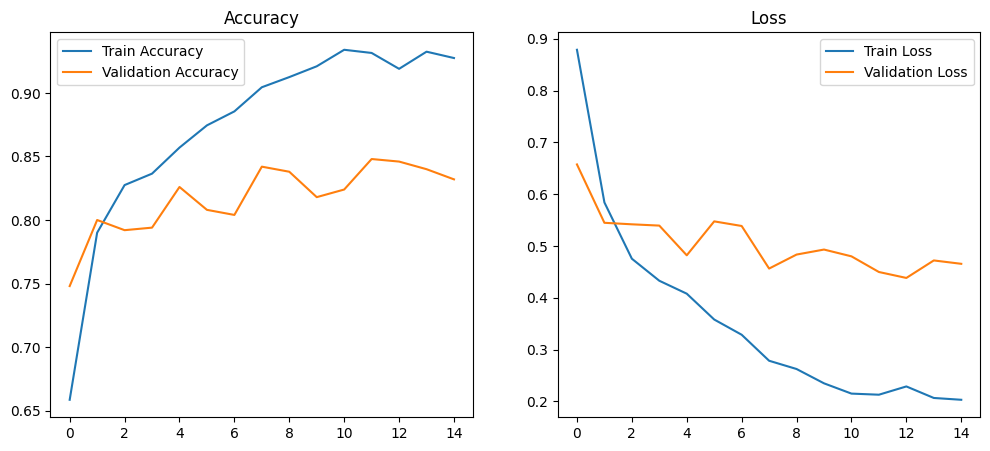

In [ ]:
# 7. Визуализация результатов
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
def predict_image(image_path, model, show_image=True):
    """
    Предсказывает класс изображения с визуализацией

    Параметры:
        image_path (str): Путь к изображению
        model (keras.Model): Загруженная модель
        show_image (bool): Показывать ли изображение

    Возвращает:
        tuple: (class_name, confidence)
    """
    try:
        # Загрузка и подготовка изображения
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img_array = keras.preprocessing.image.img_to_array(img)

        # Важно: используем ТУ ЖЕ предобработку, что и при обучении!
        img_array = keras.applications.efficientnet.preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        # Предсказание
        predictions = model.predict(img_array, verbose=0)
        predicted_idx = np.argmax(predictions)
        confidence = np.max(predictions)

        # Получаем имена классов из модели (более надежный способ)
        if hasattr(model, 'class_names'):
            class_names = model.class_names
        else:
            class_names = list(train_generator.class_indices.keys())

        class_name = class_names[predicted_idx]

        # Визуализация
        if show_image:
            plt.imshow(img)
            plt.title(f"Предсказание: {class_name}\nУверенность: {confidence:.2%}")
            plt.axis('off')
            plt.show()

        return class_name, confidence

    except Exception as e:
        print(f"Ошибка при обработке изображения: {e}")
        return None, None